In [1]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# importing data
df = pd.read_csv('../2.Downloading data/processed_high_impact_outages.csv', parse_dates=['Start', 'Finish'])
df = df.replace({r"\r|\n": " "}, regex=True)
df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code'])
df.head(5)

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Impact_Region,Reason,Duration_Hours,Impact,file_name
0,NSW,Transgrid,2021-08-30 06:05:00,2021-09-01 12:00:00,Armidale - Dumaresq (8C) 330 kV Line,3.0,4.0,0,0,0,0,1,In Progress,PTP,NSW,Commissioning,52.8,<<UPDATED since the last notification>> A cre...,2021-08-30
1,QLD,Powerlink,2021-09-01 08:30:00,2021-09-01 12:00:00,Ross No.4 288/138/19 kV Transformer,1.0,0.0,0,0,1,0,0,Planned,MTLTP,QLD,Maintenance,3.5,This is a high impact outage because the recal...,2021-08-30
2,NSW,Transgrid,2021-09-04 06:00:00,2021-09-05 17:00:00,Liddell to Muswellbrook (83) 330 kV Line,4.0,4.0,0,0,1,0,1,Planned,MTLTP,NSW,Commissioning,36.0,A credible contingency event during this plann...,2021-08-30
3,SA,ElectraNet,2021-09-06 08:00:00,2021-09-12 08:15:00,Heywood - South East No.1 275 kV Line,159.0,159.0,0,0,0,0,1,Planned,SUBMIT,SA,Commissioning,144.0,<<NEW since the last notification>> A credibl...,2021-08-30
4,QLD,Powerlink,2021-09-06 08:30:00,2021-09-10 16:00:00,Ross No.3 288/138/19 kV Transformer,4.0,6.0,0,0,1,0,0,Planned,MTLTP,QLD,Maintenance,103.2,This is a high impact outage because the recal...,2021-08-30


In [3]:
# df['Region'].value_counts()

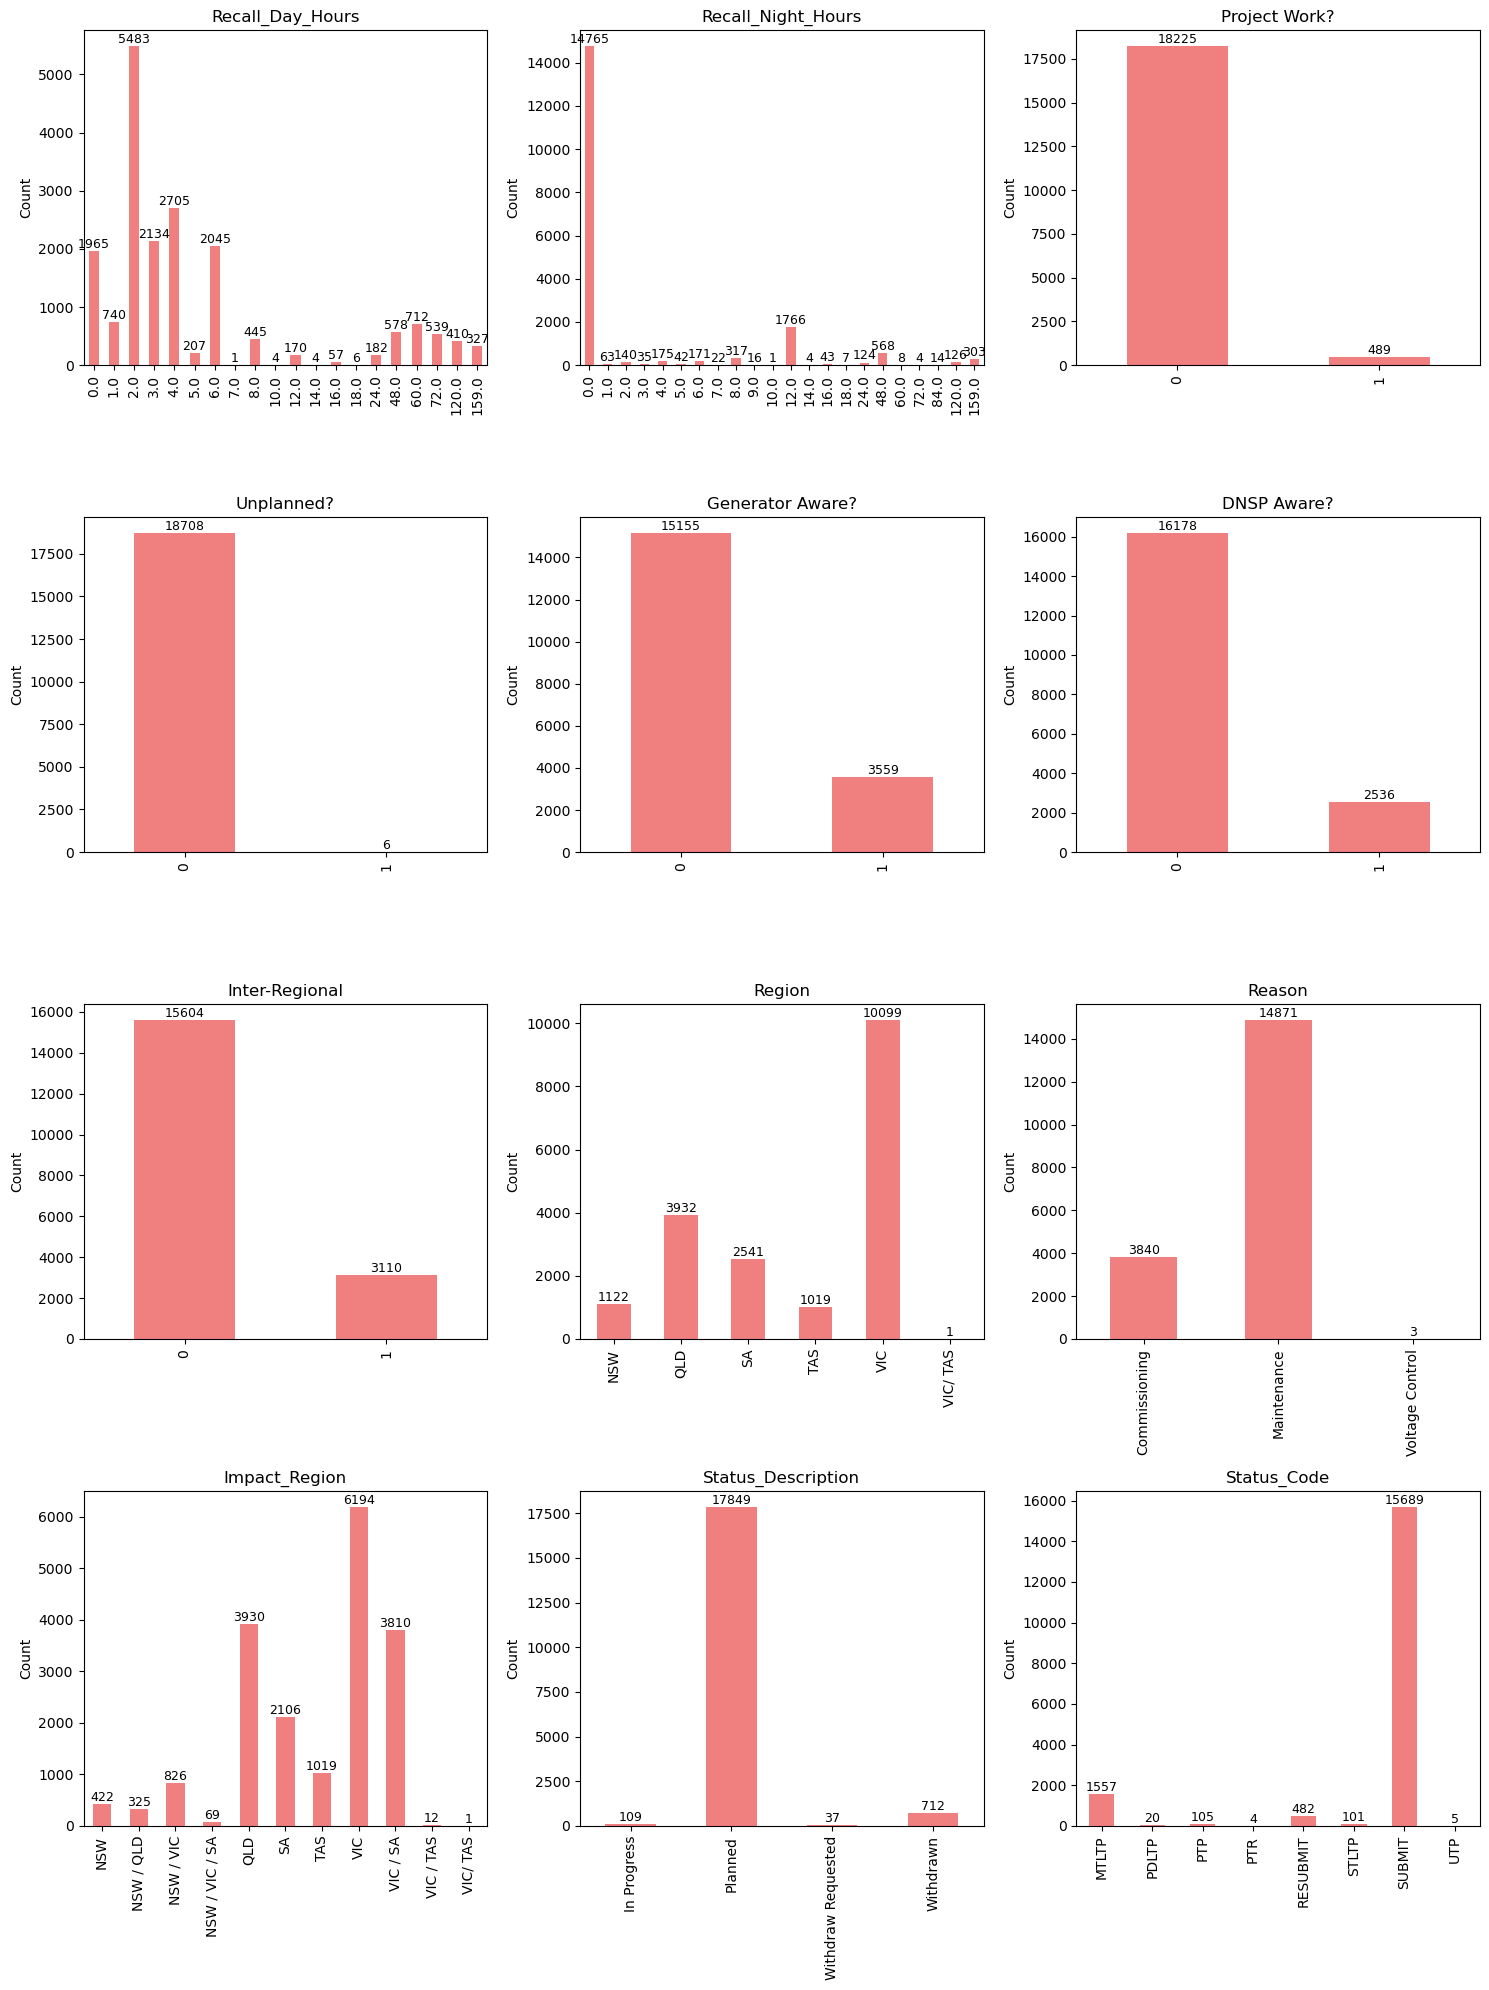

In [4]:
# Visualisation plots for the variables

bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Impact_Region', 'Status_Description', 'Status_Code']

# Combine all into one list
all_cols = numeric_cols + bool_cols + categorical_cols

n_cols = 3  # number of columns per row
n_rows = (len(all_cols) + n_cols - 1) // n_cols  # compute required rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(all_cols):
    ax = axes[idx]

    # Value counts for categorical/boolean/numeric columns
    counts = df[col].value_counts().sort_index()

    # Plot bar chart
    counts.plot(kind='bar', ax=ax, color='lightcoral')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    # Add value labels on bars
    for i, value in enumerate(counts):
        ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=9, rotation=0)

# Remove any unused subplots
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

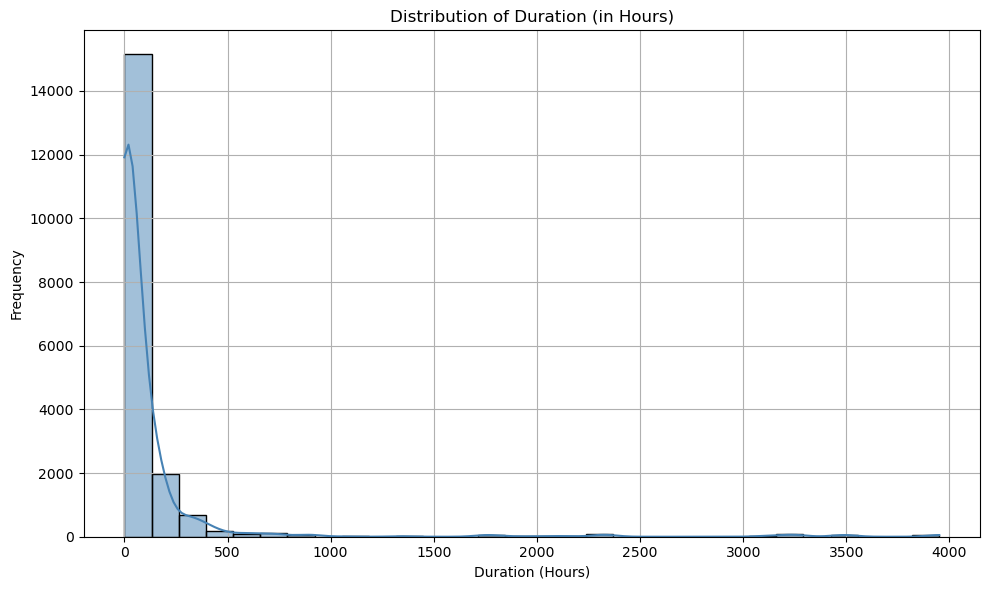

In [5]:
# Plot distribution of output variable 
# Drop NaNs
duration_data = df["Duration_Hours"].dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(duration_data, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Duration (in Hours)")
plt.xlabel("Duration (Hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
# Drop rows with missing Duration_Hours
df = df.dropna(subset=["Duration_Hours"])

# Define target and input variables, dropping some not needed variables.
y = df["Duration_Hours"]

# Drop columns not useful or that leak the target
X = df.drop(columns=["Duration_Hours", 
                     "Start", "Finish", "Network Asset", "Impact", "file_name"])

# Identify categorical and numeric features
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder='passthrough'  # keep numeric columns as they are
)

# Create pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Region', 'NSP',
                                                   'Status_Description',
                                                   'Status_Code',
                                                   'Impact_Region',
                                                   'Reason'])])),
                ('regressor', LinearRegression())])

In [16]:
# Predict
y_pred = model.predict(X_test)

# Metrics
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")


R² Score: 0.16
RMSE: 357.62


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# from sklearn.ensemble import RandomForestRegressor
# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
# ])

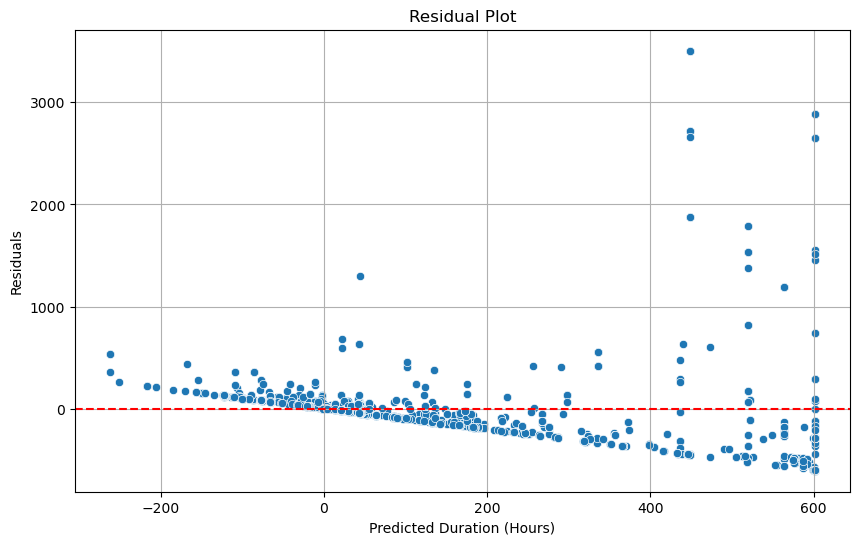

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Duration (Hours)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [13]:
import statsmodels.api as sm

# Preprocess
X_encoded = preprocessor.fit_transform(X)

# Ensure the result is a dense NumPy array (statsmodels requires it)
if hasattr(X_encoded, "toarray"):
    X_encoded = X_encoded.toarray()

# Train-test split
X_train_encoded, X_test_encoded, y_train_, y_test_ = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Add constant for intercept
X_train_encoded_const = sm.add_constant(X_train_encoded)

# Fit model
ols_model = sm.OLS(y_train_, X_train_encoded_const).fit()

# Print summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     100.8
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:58:59   Log-Likelihood:            -1.1107e+05
No. Observations:               14964   AIC:                         2.222e+05
Df Residuals:                   14931   BIC:                         2.225e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.8915     51.905      0.903      0.3